## Imports

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2

## Dataset

In [3]:
ds = tfds.load("colorectal_histology", download=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/colorectal_histology/2.0.0.incompleteD5TA5M/colorectal_histology-train.tfr…

Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.


In [4]:
ds_tr = list(tfds.as_numpy(ds)["train"])

In [5]:
ds_x = np.array([i['image'] for i in ds_tr])/255
ds_y = np.array([i['label'] for i in ds_tr])

In [6]:
x_train, x_test, y_train, y_test = train_test_split(ds_x, ds_y, test_size=0.2, shuffle=True)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.2, shuffle=True)

## Dataset Normalization

In [7]:
def one_hot_encoding(y_data):
    y_data = y_data.astype(np.int8)
    y_zeros = np.zeros(shape=(y_data.shape[0], 8))
    y_zeros[np.arange(y_data.shape[0]), y_data] =  1
    return y_zeros

In [8]:
y_train = one_hot_encoding(y_train)
y_test = one_hot_encoding(y_test)
y_val = one_hot_encoding(y_val)
x_train_64 = np.array([cv2.resize(i, (64,64)) for i in x_train])
x_test_64 = np.array([cv2.resize(i, (64,64)) for i in x_test])
x_val_64 = np.array([cv2.resize(i, (64,64)) for i in x_val])

## Creating model function

In [9]:
def model_func(x_train, x_val, x_test, shape, bn=False, drop=False, epochs=1000):
  inp_layer = tf.keras.layers.Input(shape=shape)
  conv1 = tf.keras.layers.Conv2D(2**6, kernel_size=(3,3), padding="valid", activation="relu")(inp_layer)
  if bn:
    batch1 = tf.keras.layers.BatchNormalization()(conv1)
    max_p1 = tf.keras.layers.MaxPool2D()(batch1)
  else:
    max_p1 = tf.keras.layers.MaxPool2D()(conv1)

  conv2 = tf.keras.layers.Conv2D(2**7, kernel_size=(3,3), padding="valid", activation="relu")(max_p1)
  if bn:
    batch2 = tf.keras.layers.BatchNormalization()(conv2)
    max_p2 = tf.keras.layers.MaxPool2D()(batch2)
  else:
    max_p2 = tf.keras.layers.MaxPool2D()(conv2)

  conv3 = tf.keras.layers.Conv2D(2**8, kernel_size=(3,3), padding="valid", activation="relu")(max_p2)
  if bn:
    batch3 = tf.keras.layers.BatchNormalization()(conv3)
    max_p3 = tf.keras.layers.MaxPool2D()(batch3)
  else:
    max_p3 = tf.keras.layers.MaxPool2D()(conv3)

  conv4 = tf.keras.layers.Conv2D(2**9, kernel_size=(3,3), padding="valid", activation="relu")(max_p3)
  if bn:
    batch4 = tf.keras.layers.BatchNormalization()(conv4)
    max_p4 = tf.keras.layers.MaxPool2D()(batch4)
  else:
    max_p4 = tf.keras.layers.MaxPool2D()(conv4)

  fl = tf.keras.layers.Flatten()(max_p4)
  if drop:
    drop = tf.keras.layers.Dropout(.2)(fl)
    out_layer = tf.keras.layers.Dense(8, activation="softmax")(drop)
  else:
    out_layer = tf.keras.layers.Dense(8, activation="softmax")(fl)

  model = tf.keras.Model(inputs=inp_layer, outputs=out_layer)

  es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15)
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss="CategoricalCrossentropy", metrics=["accuracy"])

  history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=64, epochs=epochs, callbacks=[es], verbose=0)
  eval = model.evaluate(x_test, y_test)
  fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,6))
  fig.suptitle('Loss and accuracy between train and val data')
  ax1.plot(history.history["loss"])
  ax1.plot(history.history["val_loss"])
  ax2.plot(history.history["accuracy"])
  ax2.plot(history.history["val_accuracy"])
  fig.show()
  return eval

## Model 1(Без сжатия картинок)

7/7 [==============================] - 0s 63ms/step - loss: 0.4809 - accuracy: 0.8250


[0.48089444637298584, 0.824999988079071]

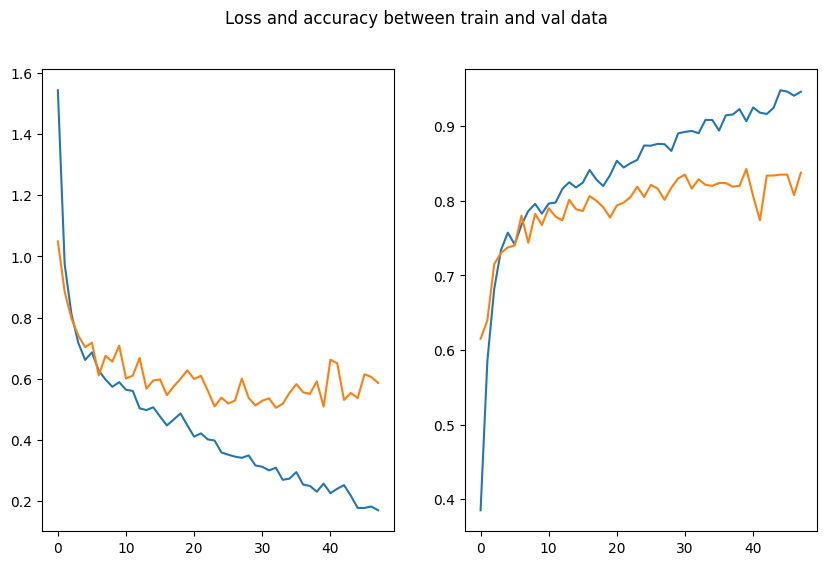

In [12]:
model_func(x_train,x_val,x_test,(150,150,3),epochs=1000)

## Model 2(С сжатием картинок)

7/7 [==============================] - 0s 35ms/step - loss: 0.6178 - accuracy: 0.7700


[0.6177637577056885, 0.7699999809265137]

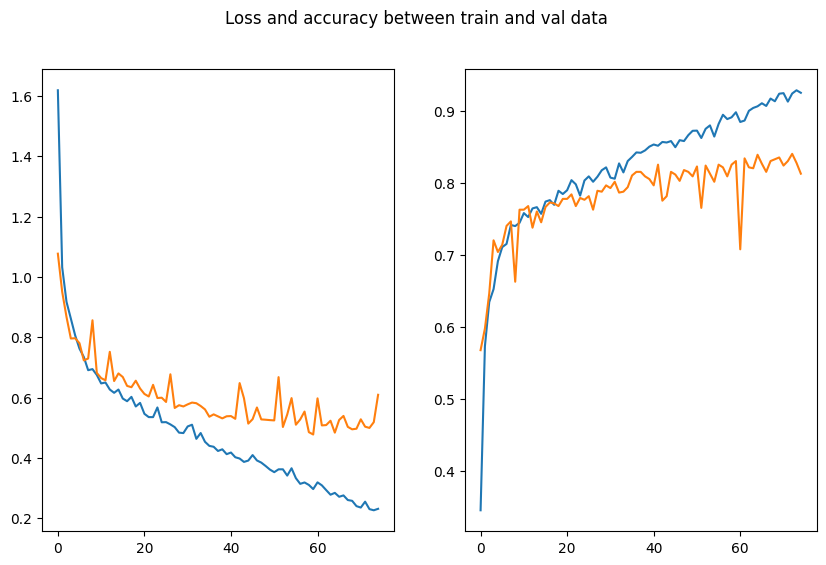

In [10]:
model_func(x_train_64,x_val_64,x_test_64,(64,64,3),epochs=1000)

## Model 3(Dropout с исходным разрешением картинок)

7/7 [==============================] - 1s 79ms/step - loss: 0.6247 - accuracy: 0.8450


[0.6246815323829651, 0.8450000286102295]

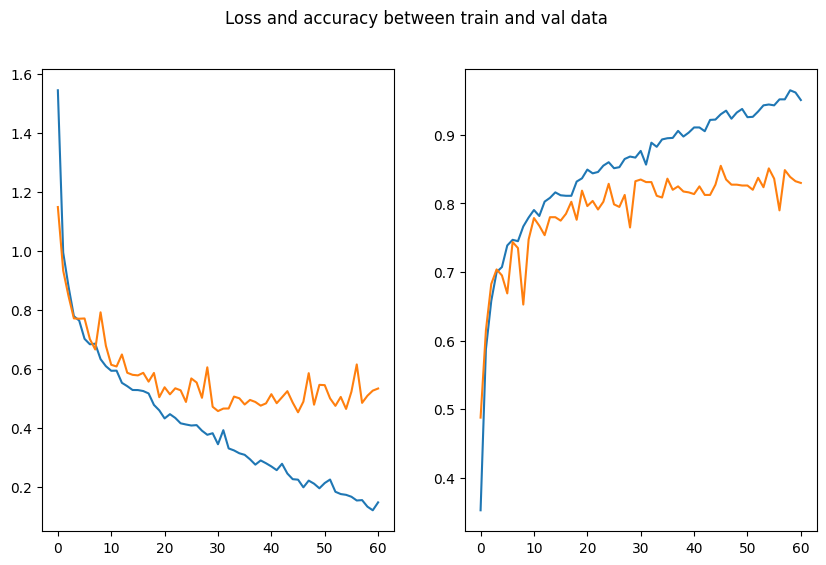

In [9]:
model_func(x_train,x_val,x_test,(150,150,3),drop=True,epochs=1000)

## Model 4(Dropout со сжатыми картинками)

7/7 [==============================] - 0s 10ms/step - loss: 0.4559 - accuracy: 0.8100


[0.4558974802494049, 0.8100000023841858]

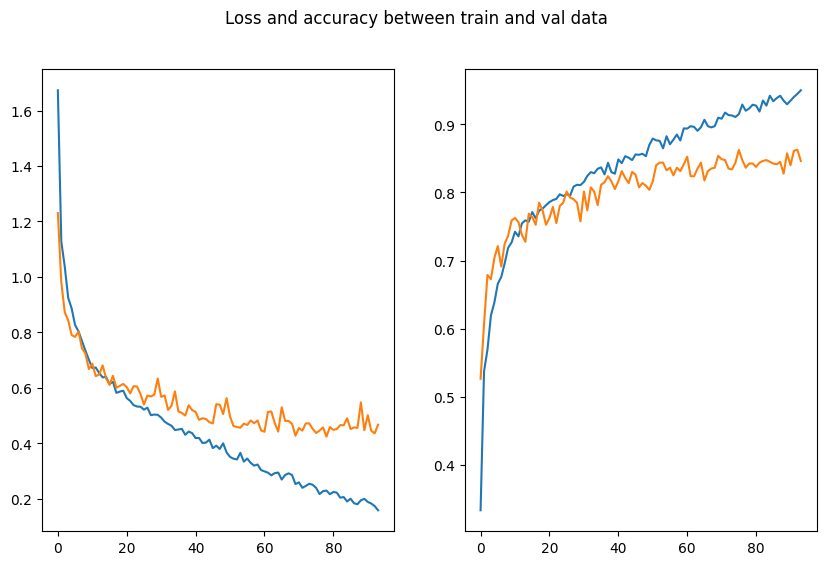

In [11]:
model_func(x_train_64,x_val_64,x_test_64,(64,64,3),drop=True,epochs=1000)

## Model 5(Batch normalization с исходным разрешением картинок)

7/7 [==============================] - 1s 84ms/step - loss: 0.4811 - accuracy: 0.8700


[0.4811156392097473, 0.8700000047683716]

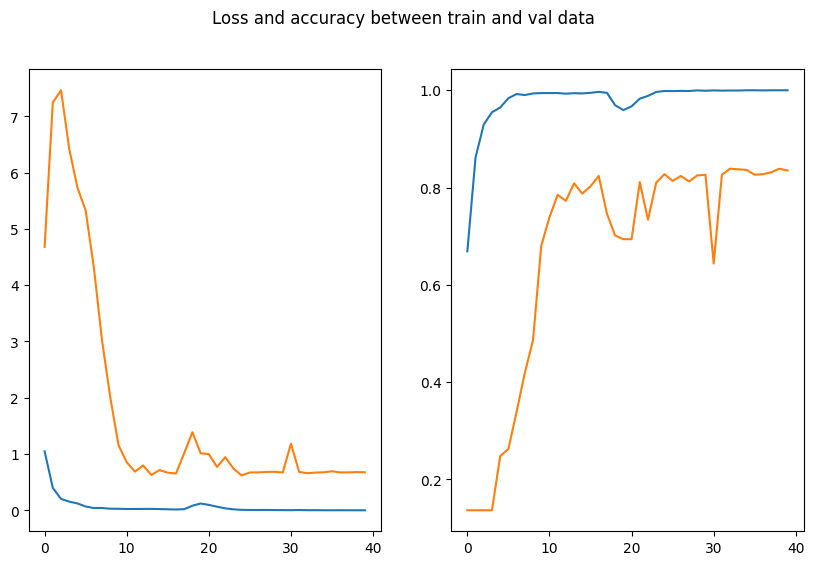

In [10]:
model_func(x_train,x_val,x_test,(150,150,3),bn=True,epochs=1000)

## Model 6(Batch normalization со сжатыми картинками)

7/7 [==============================] - 0s 36ms/step - loss: 0.8201 - accuracy: 0.6900


[0.8201484680175781, 0.6899999976158142]

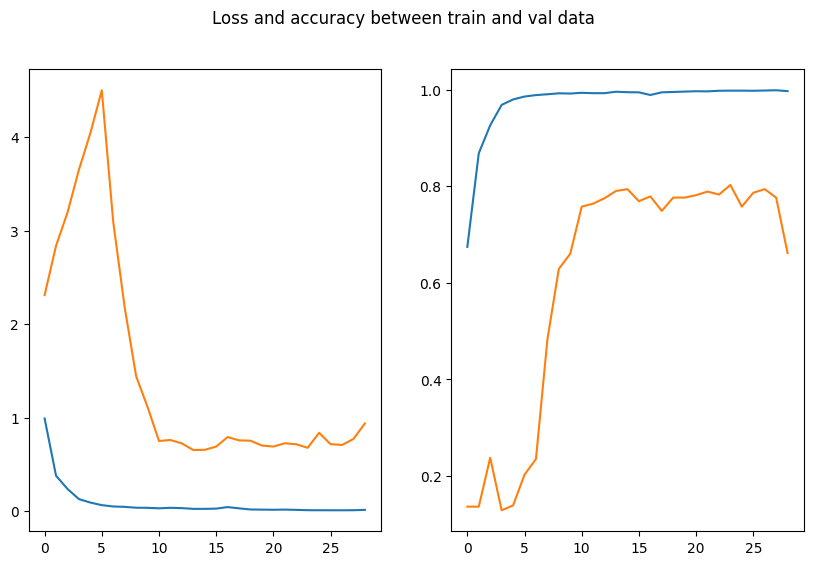

In [11]:
model_func(x_train_64,x_val_64,x_test_64,(64,64,3),bn=True,epochs=1000)